In [73]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import matplotlib.patheffects as path_effects
import itertools
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors, origin_map
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_12164\1308445948.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_12164\1308445948.py:2: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_12164\1308445948.py:3: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')


## Hypothesis testing

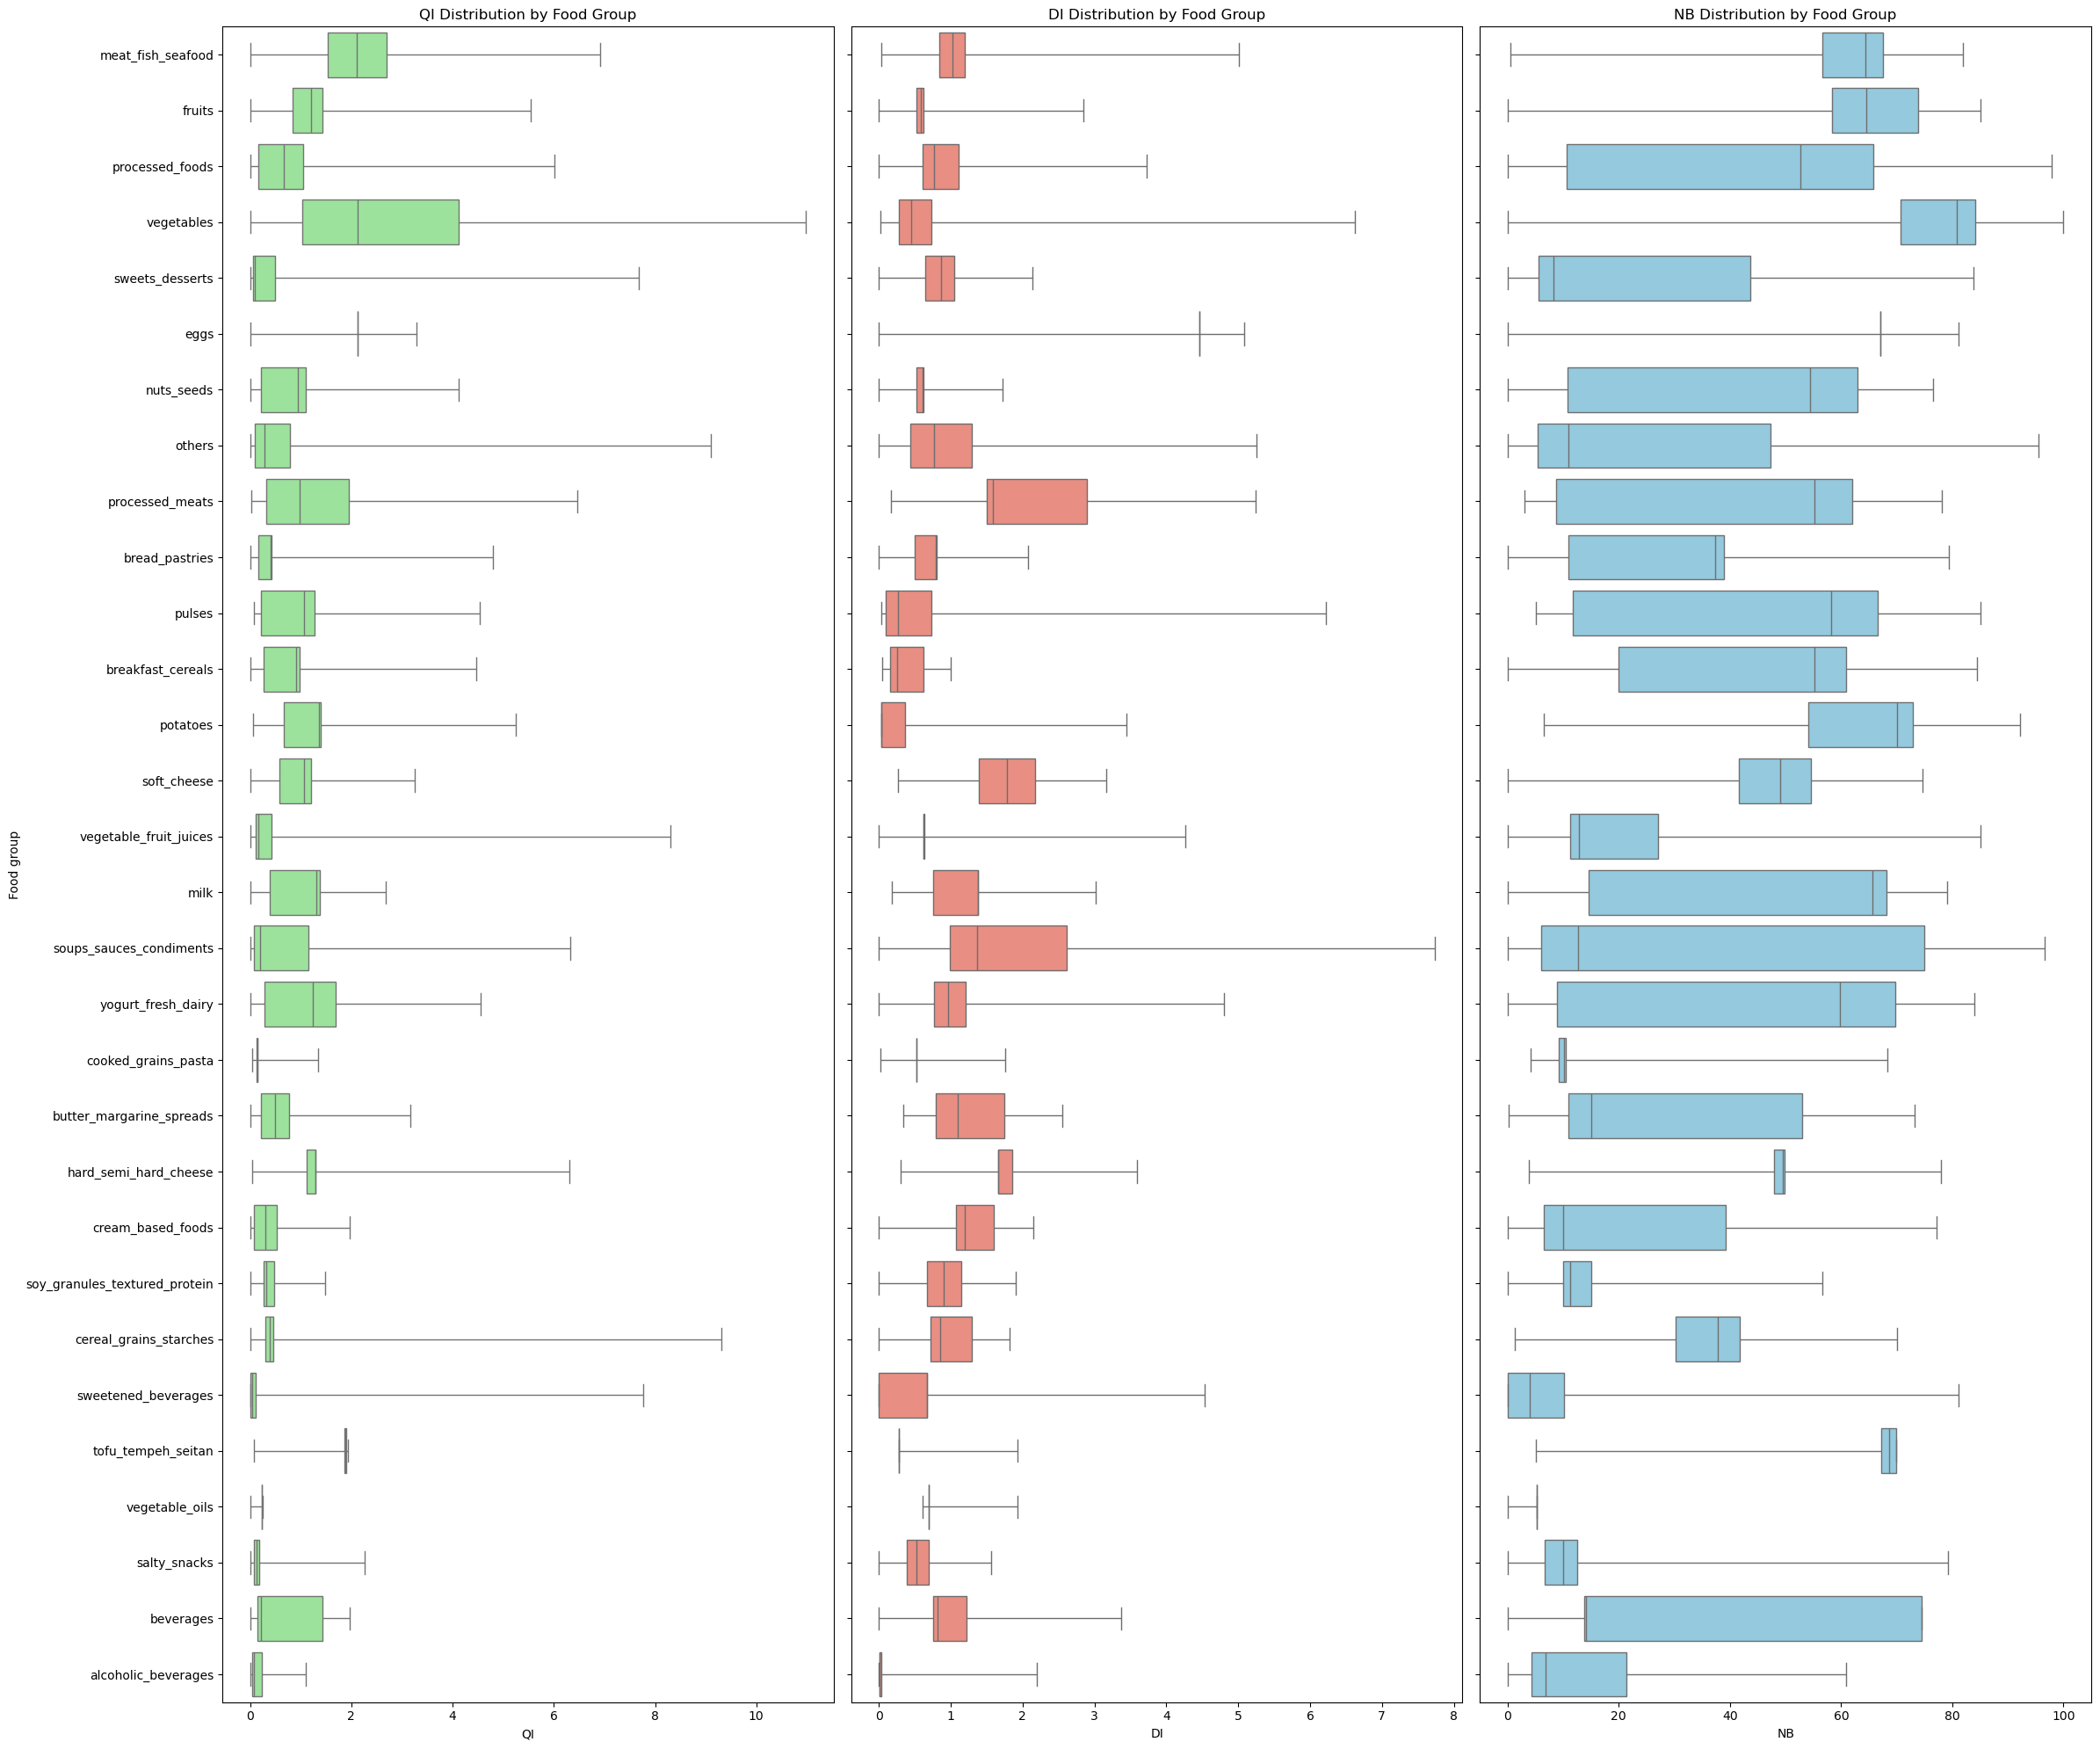

In [65]:
metrics = ['QI', 'DI', 'NB']
colors  = ['lightgreen', 'salmon', 'skyblue']

fig, axes = plt.subplots(ncols=3, figsize=(24, 20), sharey=True)

for ax, metric, c in zip(axes, metrics, colors):
    sns.boxplot(
        x=metric,
        y='food_group',
        data=df_food_clean_scaled,
        whis=(0, 100),
        color=c,
        ax=ax
    )
    ax.set_title(f'{metric} Distribution by Food Group')
    ax.set_xlabel(f'{metric}')
    if ax is not axes[0]:
        ax.set_ylabel('')     # only label y on the first plot
    else:
        ax.set_ylabel('Food group')

plt.tight_layout()
plt.show()

### Normalisation hypothesis testing

- D'Agostino K2 test : = measure of departure from normality. Aim to gauge the compatibility of a given data with the null hypothesis that the data is a realization of independent, identically distributed Gaussian random variables
-

In [ ]:
# Agostino K2 test
normaltest_results = []
for group, subdf in df_food_clean_scaled.groupby('food_group'):
    stat, p = stats.normaltest(subdf['DI'])
    normaltest_results.append({
        'food_group': group,
        'K2_stat':   stat,
        'p_value':   p
    })

normaltest_df = pd.DataFrame(normaltest_results).set_index('food_group').sort_values('p_value')

In [63]:
# Anderson-Darling A2 test
anderson_results = []
for group, subdf in df_food_clean_scaled.groupby('food_group'):
    res = stats.anderson(subdf['NB'], dist='norm')
    anderson_results.append({
        'food_group': group,
        'A2_stat':    res.statistic,
        'critical_5%':res.critical_values[2]  
    })

anderson_df = pd.DataFrame(anderson_results).set_index('food_group').sort_values('A2_stat', ascending=False)

**Observation** : QI, DI and NB distributions by food group are not normal. They are skewed, have long tails and contain extreme outliers, therefore they do not follow a symmetric bell shape.  
It is not possible to execute a parametric test (t-test or ANOVA) as the distribution is not normal

In [70]:
# 1. Kruskal–Wallis omnibus test
groups = [
    grp['NB'].values 
    for _, grp in df_food_clean_scaled.groupby('food_group')
]
H, p_kruskal = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.2f}, p = {p_kruskal:.3g}")

if p_kruskal < 0.05:
    print("→ Significant differences exist between at least two groups.")
else:
    print("→ No overall difference detected; you can stop here.")

# 2. Dunn’s post-hoc pairwise comparisons
#    (correcting for multiple tests with Bonferroni)
dunn_results = sp.posthoc_dunn(
    df_food_clean_scaled, 
    val_col='NB', 
    group_col='food_group', 
    p_adjust='bonferroni'
)

# Make it a bit prettier
dunn_results.index.name = 'Group A'
dunn_results.columns.name = 'Group B'
print("\nDunn post-hoc p-values (Bonferroni adjusted):")
print(dunn_results)

# 3. (Optional) extract only the significant pairs
sig_pairs = (
    dunn_results.stack()
    .reset_index()
    .query('0 < p_adjusted < 0.05')
    .rename(columns={0: 'p_value'})
)
print("\nSignificant group differences (p < .05):")
print(sig_pairs)

Kruskal–Wallis H = 59005.48, p = 0
→ Significant differences exist between at least two groups.

Dunn post-hoc p-values (Bonferroni adjusted):
Group B                        alcoholic_beverages      beverages  \
Group A                                                             
alcoholic_beverages                   1.000000e+00   0.000000e+00   
beverages                             0.000000e+00   1.000000e+00   
bread_pastries                        0.000000e+00  8.284016e-169   
breakfast_cereals                     0.000000e+00   7.780201e-02   
butter_margarine_spreads              2.769295e-19   9.400423e-29   
cereal_grains_starches                0.000000e+00   9.662965e-99   
cooked_grains_pasta                   1.775499e-04  1.875324e-150   
cream_based_foods                     8.247818e-49  1.054707e-305   
eggs                                  0.000000e+00  5.724701e-158   
fruits                                0.000000e+00  1.898896e-272   
hard_semi_hard_cheese        

UndefinedVariableError: name 'p_adjusted' is not defined

In [74]:
# 1. Group your data by food_group
groups = {
    name: grp['NB'].values
    for name, grp in df_food_clean_scaled.groupby('food_group')
}

# 2. Generate all unique pairs of groups
pairs = list(itertools.combinations(groups.keys(), 2))

# 3. Run Mann–Whitney U for each pair
results = []
for g1, g2 in pairs:
    u_stat, p_unc = mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')
    results.append({
        'group1': g1,
        'group2': g2,
        'U_stat': u_stat,
        'p_uncorrected': p_unc
    })

# 4. Bonferroni‐correct the p-values
p_uncorrected = [r['p_uncorrected'] for r in results]
rej, p_adjusted, _, _ = multipletests(p_uncorrected, alpha=0.05, method='bonferroni')

# 5. Attach adjusted p-values and significance flags
for r, p_adj, is_sig in zip(results, p_adjusted, rej):
    r['p_bonferroni'] = p_adj
    r['significant'] = is_sig

# 6. Create a DataFrame for easy inspection
posthoc_df = pd.DataFrame(results)
posthoc_df = posthoc_df.sort_values('p_bonferroni')
print(posthoc_df[['group1','group2','U_stat','p_uncorrected','p_bonferroni','significant']])

                  group1                 group2      U_stat  p_uncorrected  \
0    alcoholic_beverages              beverages   7026273.0       0.000000   
28   alcoholic_beverages     yogurt_fresh_dairy   7848985.0       0.000000   
24   alcoholic_beverages     tofu_tempeh_seitan    670743.5       0.000000   
27   alcoholic_beverages             vegetables   7337442.5       0.000000   
1    alcoholic_beverages         bread_pastries  32531501.0       0.000000   
..                   ...                    ...         ...            ...   
384         salty_snacks        sweets_desserts   7082582.0       0.096575   
417  sweetened_beverages         vegetable_oils    108053.0       0.139002   
37             beverages  hard_semi_hard_cheese   4715827.0       0.995582   
38             beverages      meat_fish_seafood  12975702.0       0.710081   
30             beverages      breakfast_cereals   4974960.5       0.326435   

     p_bonferroni  significant  
0             0.0         True